## Autodiff Sequence Space Jacobian
The SSJ method implemented before has some issues with numerical error, since it uses a one-sided finite differences differentiation method, which doesn't deal with nonlinearity well. Here, we implement the same thing using JAX autodifferentiation which should remove those errors.

#### Preliminaries

In [1]:
## load some packages
from scipy import sparse as sp_sparse  # use this to find an eigenvector in the steady state
from jax.experimental import sparse
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import jax.numpy as jnp  # we'll need autodifferentiation compatible arrays
import jax
jax.config.update('jax_enable_x64', True)  # jax uses 32 bit numbers for some reason

## config
# params
ALPHA = 1/3
BETA = 0.98
GAMMA = 2.
DELTA = 0.05
A_MIN = 0.  # borrowing constraint
PRODUCTIVITY = jnp.array([1, 2.5])  # low and high productivity
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = jnp.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix
RHO_Z = 0.9
SIGMA_Z = 0.02

# grids
A_MAX = 500
N_A = 501
GRID = jnp.linspace(A_MIN**0.25, A_MAX**0.25, N_A)**4

#### The Model
The model is the same as the one solved using finite differences SSJ methods.

#### Labor
Find the stationary distribution of labor supply using the eigenvector of the transition matrix.

In [2]:
# get distribution
vals, vecs = jnp.linalg.eig(TRAN_MAT)
i = jnp.abs(vals).argmax()  # dominant eigenvactor
L_dist = vecs[:, i].real
L_dist /= L_dist.sum()

# aggregate
L = PRODUCTIVITY @ L_dist

#### Aggregates
Using the model DAG, we can solve for $W_t$ and the $R_t$ using just $K_{t-1}$ and $Z_t$. We implement this here to characterize the economy in terms of just $K_{t-1}$ and $Z_t$.

In [3]:
@jax.jit
def get_aggs(K_l, Z_t=1., L_t=L):  # 1 is steady state Z
    '''
    Solve for W, R, and Y given a capital value
    '''
    R_t = ALPHA * Z_t * K_l**(ALPHA-1) * L_t**(1-ALPHA) + 1 - DELTA
    W_t = (1-ALPHA) * Z_t  * K_l**ALPHA * L_t**(-ALPHA)
    Y_t = Z_t * K_l**ALPHA * L_t**(1-ALPHA)

    return R_t, W_t, Y_t

#### Endogenous Grid Method
The EGM helpers are identical, just written to use JAX syntax instead of numpy.

In [4]:
@jax.jit
def linear_interpolation(x, y, X):  # helper numberical methods function we need
    '''
    Performs a linear interpolation of x and y at X
    '''
    # setuo
    n = len(x)

    # create and return interpolation
    idx = jnp.minimum(jnp.maximum(jnp.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
    x_l = x[idx-1]  # values below the x
    y_l = y[idx-1]
    x_h = x[idx]  # values above the x
    y_h = y[idx]
    m = (y_h - y_l) / (x_h - x_l)  # slope
    return y_l + m * (X - x_l)  


@jax.jit
def g_interp(b, b_l, b_t=GRID):  # gets a savings funciton g
    '''
    Savings function for a given a_t maps to a_p
    '''
    # setup
    num_endows = b_l.shape[1]

    # interpolate
    a_pr = jnp.empty(b_l.shape)
    for i in range(num_endows):
        a_pr = a_pr.at[:, i].set(linear_interpolation(b_l[:, i], b_t, b))
    
    # borrowing constraint
    a_pr = jnp.where(a_pr < A_MIN, A_MIN, a_pr)
    
    return a_pr


@jax.jit
def euler_back(g_p, R_t, W_t, R_p, W_p, b_t=GRID, exog_tran_mat=TRAN_MAT, productivity=PRODUCTIVITY):  # egm core
    '''
    Finds a savings function given a old guess for a savings function
    and gridpoitns

    g_p shold be the savings levels now that map to the gird points 
    '''
    c_p = R_p * b_t[:, None] + W_p * productivity - g_interp(b_t, g_p)  # get next period consumption
    expec_dc_p = c_p ** (-GAMMA) @ exog_tran_mat  # take expectation with deriavtive
    c_t = (BETA * R_p * expec_dc_p)**(-1/GAMMA)  # consumption now
    b_l = 1/R_t * (b_t[:, None] + c_t - W_t * productivity)  # savings at the start of the period

    return b_l

#### Transition Matrix
Once we have a policy function, we want to make a transition matrix between the gridpoints to find the distribution of wealth.

In [5]:
@jax.jit
def make_tran_mat(b_t, b_l=GRID, exog_tran_mat=TRAN_MAT):
    '''
    Makes the wealth distribution transition matrix given a savings rule
    from each of the gridpoints
    '''
    # figure out where values go
    idxs = jnp.minimum(jnp.searchsorted(b_l, b_t, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = jnp.maximum((b_l[idxs] - b_t) / (b_l[idxs] - b_l[idxs-1]), 0.)
    # # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low efficiency: capital now -> capital later
    data_l = jnp.concatenate((p_l[:, 0], p_h[:, 0]))
    data_l = data_l
    row_l = jnp.concatenate((idxs[:, 0]-1, idxs[:, 0]))
    col_l = jnp.concatenate((jnp.arange(N_A), jnp.arange(N_A)))

    # high efficicency: capital now -> capital later
    data_h = jnp.concatenate((p_l[:, 1], p_h[:, 1]))
    data_h = data_h
    row_h = jnp.concatenate((idxs[:, 1]-1, idxs[:, 1]))
    col_h = jnp.concatenate((jnp.arange(N_A), jnp.arange(N_A)))

    # create overall transition matrix
    data = jnp.concatenate((
            data_l * exog_tran_mat[0, 0], data_l * exog_tran_mat[1, 0],
            data_h * exog_tran_mat[0, 1], data_h * exog_tran_mat[1, 1],
        ))
    row = jnp.concatenate((
            row_l, N_A + row_l,  # top vector (employed) is on top
            row_h, N_A + row_h,
        ))
    col = jnp.concatenate((
            col_l, col_l,  # left half of transition matrix 
            N_A + col_h, N_A + col_h,  # right half of transition matrix
        ))
    tran_mat = sparse.BCOO((data, jnp.column_stack((row, col))), shape=(2*N_A, 2*N_A))
    # idxs = jnp.argsort(row)  # needs to be ordered right
    # tran_mat = sparse.CSR((data[idxs], col[idxs], jnp.searchsorted(row[idxs], jnp.arange(2*N_A+1)).astype(col.dtype)), shape=(2*N_A, 2*N_A))

    return tran_mat

#### Aggregator
Aggregate capital to get the total capital in the economy.

In [6]:
@jax.jit
def agg_K(dist, grid=GRID):
    return (grid * dist.T).sum()

#### Steady State
Use the endogenous grid method to find the steady state for the economy.

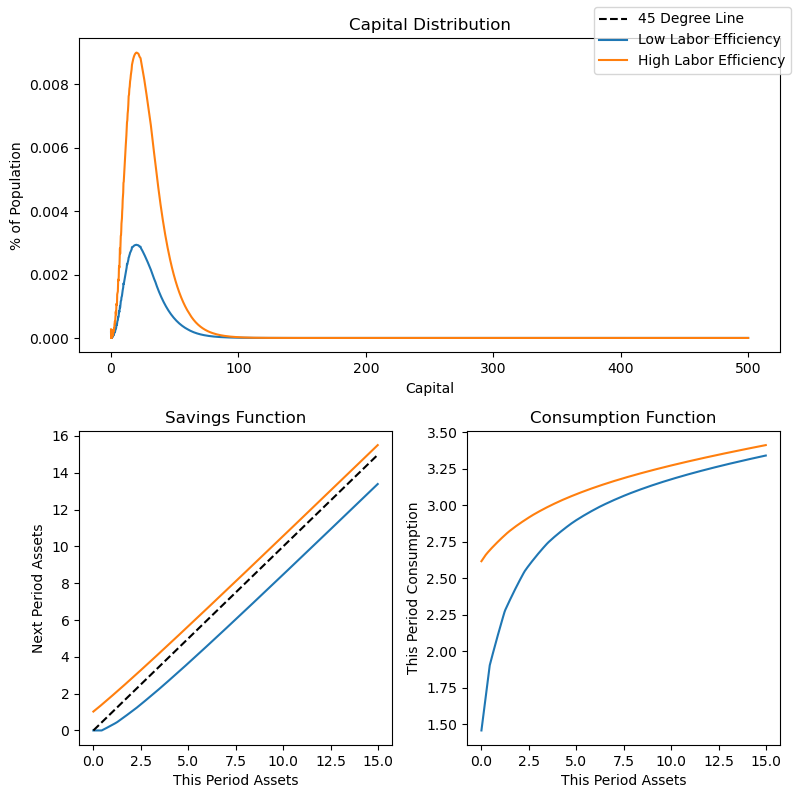

In [7]:
# jax doesn;t like to jit conditionals, see if theres a faster way to do this 
def egm(b_l, R, W, max_iter=10000, tol=1e-14):
    for _ in range(max_iter):
        # get new consumption function
        last_b_l = b_l
        b_l = euler_back(b_l, R, W, R, W)

        # exit condition
        diff = jnp.abs(b_l - last_b_l).max()
        if diff < tol:
            break
    else:
        print('Policy Rule: Max iteration count exceeded')
    
    return b_l


def get_dist(b_t):
    '''
    Use the eignevector of a sparse matrix to find the stationary distribution
    of capital
    '''
    # get transition matrix
    tran_mat = make_tran_mat(b_t)
    # sp_tran_mat = sp_sparse.csr_array((tran_mat.data, tran_mat.indices, tran_mat.indptr), shape=tran_mat.shape)
    sp_tran_mat = sp_sparse.csr_array((tran_mat.data, (tran_mat.indices[:, 0], tran_mat.indices[:, 1])), shape=tran_mat.shape)
    # we use a scipy csr array to implement the scipy eigenvector finder
    # more memory efficeint way would use a linear opperator, so that might be worth using for high dimenstional systems 

    # use eigenvalues to get the steady state distribution of capital
    dist = sp_sparse.linalg.eigs(sp_tran_mat, k=1)[1].real  # get dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    return dist, tran_mat


b_l0 = [10 + 0.1 * jnp.tile(GRID, PRODUCTIVITY.shape+(1,)).T]  # intial guess we make here and update in the function to make the next iteration faster
def simulate_K(K, grid=GRID, b_l0=b_l0):
    R, W, Y = get_aggs(K)  # aggregate variables
    b_l = egm(b_l0[0], R, W)  # use the egm to solve for a policy rule
    b_l0[0] = b_l  # make next iteration faster
    dist, tran_mat = get_dist(g_interp(grid, b_l))  # get the distribution of capital
    K_d = agg_K(dist)

    return K_d, R, W, Y, b_l, dist, tran_mat


# params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-10  # actual capital will be within this distance of capital
K_0 = ((1/BETA + DELTA - 1) / ALPHA / L**(1-ALPHA))**(1/(ALPHA-1))  # steady state RBC K

# solve model
K_ss = brentq(lambda K: simulate_K(K)[0] - K, K_0, K_0+2., xtol=capital_tol, maxiter=capital_max_iter)
_, R_ss, W_ss, Y_ss, b_l_ss, dist_ss, tran_mat_ss = simulate_K(K_ss)
g_ss = lambda b_l: g_interp(b_l, b_l_ss)
c_ss = lambda b_l: R_ss*b_l[:, None] + W_ss*PRODUCTIVITY - g_ss(b_l)

# setup plot
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(GRID, dist_ss[:, 0], label='Low Labor Efficiency')
axtop.plot(GRID, dist_ss[:, 1], label='High Labor Efficiency')
n = (GRID < 15).sum()  # look at first n gridpoits, most the interesting stuff happens early
axs[1, 0].plot(GRID[:n], g_ss(GRID)[:n])
axs[1, 0].plot([A_MIN, GRID[n-1]], [A_MIN, GRID[n-1]], 'k--', label='45 Degree Line')
axs[1, 1].plot(GRID[:n], c_ss(GRID)[:n])

# final things
fig.legend()
fig.tight_layout()

#### Impulse Response
Like before, we'll assume a $T$ period shock sequence and create Jacobians to solve for the path for aggregate variables during the shock.

In [8]:
T = 500

# shock path
Z_ss = 1.
dZ_path = SIGMA_Z * jnp.full(T, RHO_Z) ** jnp.arange(T)  # linearized (no exp)

#### Fake News Algorithm
We'll reimplement the fake news algorithm using automatic differentiation for each block instead of forward, finite differences differentiation. Then, we'll use the chain rule to map everything together.

In [9]:
# get needed derivaties
dY_db_l = sparse.BCOO.fromdense(jax.jacfwd(lambda b_l: (g_interp(GRID, b_l) * dist_ss).sum())(b_l_ss))
ddist_db_l = sparse.BCOO.fromdense(jax.jacfwd(lambda b_l: (make_tran_mat(g_interp(GRID, b_l.reshape((-1, 2), order='F'))) @ dist_ss.ravel('F')))(b_l_ss.ravel('F')))
db_l_db_l = sparse.BCOO.fromdense(jax.jacfwd(lambda b: euler_back(b.reshape((-1, 2), order='F'), R_ss, W_ss, R_ss, W_ss).ravel('F'))(b_l_ss.ravel('F')))

# @jax.jit  # cant do deriviatives with this on
def back_iter(i, b_l_ss=b_l_ss, R_ss=R_ss, W_ss=W_ss, grid=GRID, db_l_db_l=db_l_db_l, dY_db_l=dY_db_l, ddist_db_l=ddist_db_l):
    # setup
    curly_Y = jnp.empty(T)  # curly_Y[s] represents effect on aggregates at time 0 on shock at time s
    curly_D = jnp.empty((T, len(grid), 2))  # curly_D[s] represents effect on period 1 distribution of shock at time s
    get_d_b_l = lambda db_l: (db_l_db_l @ db_l.ravel('F')).reshape((-1, 2), order='F')
    get_curly_Y = lambda db_l: (dY_db_l * db_l).sum()
    get_curly_D = lambda db_l: (ddist_db_l @ db_l.ravel('F')).reshape((-1, 2), order='F')
    
    # initial period, pertrurbed R_t or W_t
    db_l = jax.jacfwd(euler_back, 1 + i)(b_l_ss, R_ss, W_ss, R_ss, W_ss)
    curly_Y = curly_Y.at[0].set(get_curly_Y(db_l))
    curly_D = curly_D.at[0].set(get_curly_D(db_l))

    # second period, pertrurbed R_p or W_p
    db_l = get_d_b_l(db_l) + jax.jacfwd(euler_back, 3 + i)(b_l_ss, R_ss, W_ss, R_ss, W_ss)
    curly_Y = curly_Y.at[1].set(get_curly_Y(db_l))
    curly_D = curly_D.at[1].set(get_curly_D(db_l))

    # get later periods, R_ss and W_ss
    for s in range(2, T):
        db_l = get_d_b_l(db_l)
        curly_Y = curly_Y.at[s].set(get_curly_Y(db_l))
        curly_D = curly_D.at[s].set(get_curly_D(db_l))

    return curly_Y, curly_D


@jax.jit
def expect_vectors(tran_mat_ss=tran_mat_ss, b_l_ss=b_l_ss, grid=GRID):
    '''
    Find expected vectors
    '''
    # initialize
    curly_E = jnp.empty((T-1, len(GRID), 2))  # curly_E[s] represents expected output at time s

    # expect = transition matrix * wher eyou exepcetd to be last period
    curly_E = curly_E.at[0].set(g_interp(grid, b_l_ss))  # how much they decide to spend (known now)
    for t in range(1, T-1):
        curly_E = curly_E.at[t].set((tran_mat_ss.T @ curly_E[t-1].ravel('F')).reshape((-1, 2), order='F'))

    return curly_E


@jax.jit
def fake_news(curly_Y, curly_D, curly_E):
    '''
    Make the fake news matrix from the curlys
    '''
    # initialize and assign top row
    fake_news_mat = jnp.empty((T, T)).at[0].set(curly_Y)

    # make bottom rows
    fake_news_mat = fake_news_mat.at[1:].set((curly_D[None, :, :, :] * curly_E[:, None, :, :]).sum(axis=(-1, -2)))  # vstack?

    return fake_news_mat


@jax.jit
def jacobian_from_fake_news(fake_news_mat):
    '''
    Make the jacobian from the fake news matrix
    '''
    # initialize it with the fake news matrix, we'll add elemtns to iteself to make the jacobians
    jacobian = 1. * fake_news_mat  # 1* to make a copy

    # add down the diaganel
    for i in range(1, jacobian.shape[0]):
        jacobian = jacobian.at[i, 1:].set(jacobian[i, 1:] + jacobian[i-1, :-1])
    
    return jacobian


def get_jacobians(n_x=2, b_l_ss=b_l_ss, tran_mat_ss=tran_mat_ss, R_ss=R_ss, W_ss=W_ss, grid=GRID, db_l_db_l=db_l_db_l, dY_db_l=dY_db_l, ddist_db_l=ddist_db_l):
    '''
    Find the jacobians (and fake new matricies) from the vectors
    '''
    # colelct results here
    jacobians = []
    fake_news_mats = []

    # get expectaions (contant for all varibales we take it with respect to)
    curly_E = expect_vectors(tran_mat_ss=tran_mat_ss, b_l_ss=b_l_ss, grid=grid)

    # get each variables jacobian
    for i in range(n_x):
        curly_Y, curly_D = back_iter(i, b_l_ss=b_l_ss, R_ss=R_ss, W_ss=W_ss, grid=GRID, db_l_db_l=db_l_db_l, dY_db_l=dY_db_l, ddist_db_l=ddist_db_l)
        fake_news_mat = fake_news(curly_Y, curly_D, curly_E)
        fake_news_mats.append(fake_news_mat)
        jacobians.append(jacobian_from_fake_news(fake_news_mat))
    
    return jacobians, fake_news_mats

# break to keep jits compiled

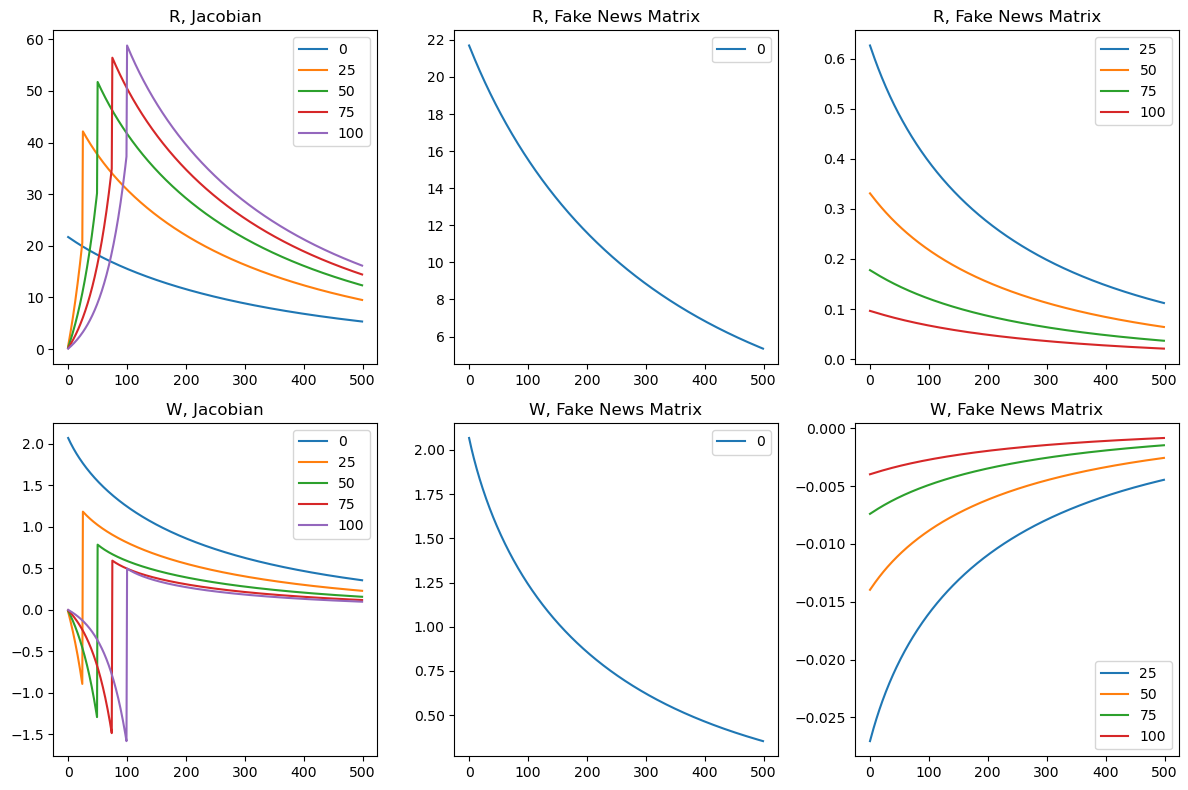

In [10]:
# get the jacobians
jacobians, fake_news_mats = get_jacobians()  # order is R, W within each

# plot columns
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(8)
axs[0, 0].set_title('R, Jacobian')
axs[0, 1].set_title('R, Fake News Matrix')
axs[0, 2].set_title('R, Fake News Matrix')
axs[1, 0].set_title('W, Jacobian')
axs[1, 1].set_title('W, Fake News Matrix')
axs[1, 2].set_title('W, Fake News Matrix')

# times we'll have a line for
ts = jnp.arange(0, 101, 25)

# plot jacobians
axs[0, 0].plot(jacobians[0][:, ts], label=ts)
axs[1, 0].plot(jacobians[1][:, ts], label=ts)

# plot zero time fake news matrix
axs[0, 1].plot(fake_news_mats[0][:, 0], label=0)
axs[1, 1].plot(fake_news_mats[1][:, 0], label=0)

# plot later time fake news matrix
axs[0, 2].plot(fake_news_mats[0][:, ts[1:]], label=ts[1:])
axs[1, 2].plot(fake_news_mats[1][:, ts[1:]], label=ts[1:])

# final things
for i in range(axs.size):
    axs.take(i).legend()
fig.tight_layout()

#### Make G
Make the G matrix used for impulse response functions.

In [11]:
@jax.jit
def get_derivs(K_ss=K_ss, Z_ss=Z_ss):
    '''
    Gets the derivates of R, W, and Y with respect to K and Z
    '''
    # these could also be done with jax but idc
    dRdK = ALPHA * (ALPHA - 1) * Z_ss * K_ss**(ALPHA-2) * L**(1-ALPHA)
    dWdK = ALPHA * (1 - ALPHA) * Z_ss * K_ss**(ALPHA-1) * L**(-ALPHA)
    dYdK = ALPHA * Z_ss * K_ss**(ALPHA-1) * L**(1-ALPHA)
    dRdZ = ALPHA * K_ss**(ALPHA-1) * L**(1-ALPHA)
    dWdZ = (1 - ALPHA) * K_ss**(ALPHA) * L**(-ALPHA)
    dYdZ = K_ss**ALPHA * L**(1-ALPHA)

    return dRdK, dWdK, dYdK, dRdZ, dWdZ, dYdZ


@jax.jit
def get_G(J_R, J_W, Z_ss=Z_ss, K_ss=K_ss):
    '''
    Make the impulse response solution matrix
    '''
    # get static derivatives
    dRdK, dWdK, _, dRdZ, dWdZ, _ = get_derivs(K_ss, Z_ss)

    # get jacobians
    F_K = J_R * dRdK + J_W * dWdK - jnp.eye(T)  # idk if this deals with time right
    F_Z = J_R * dRdZ + J_W * dWdZ

    # get G
    G = -jnp.linalg.solve(F_K, F_Z)

    return G

# break to keep jits compiled

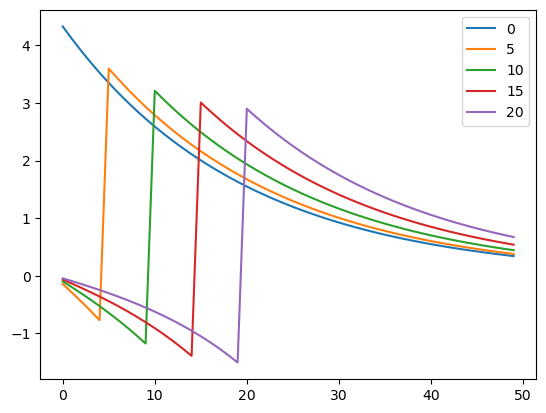

In [12]:
# get the results
G = get_G(*jacobians)

# plot the columns of G
ts = jnp.arange(0, 25, 5)
plt.plot(G[:50, ts], label=ts)
plt.legend()

#### Impulse Response Function
Once we have all the setup done, running an impulse response is really easy (and identical to with numerical differentiation).

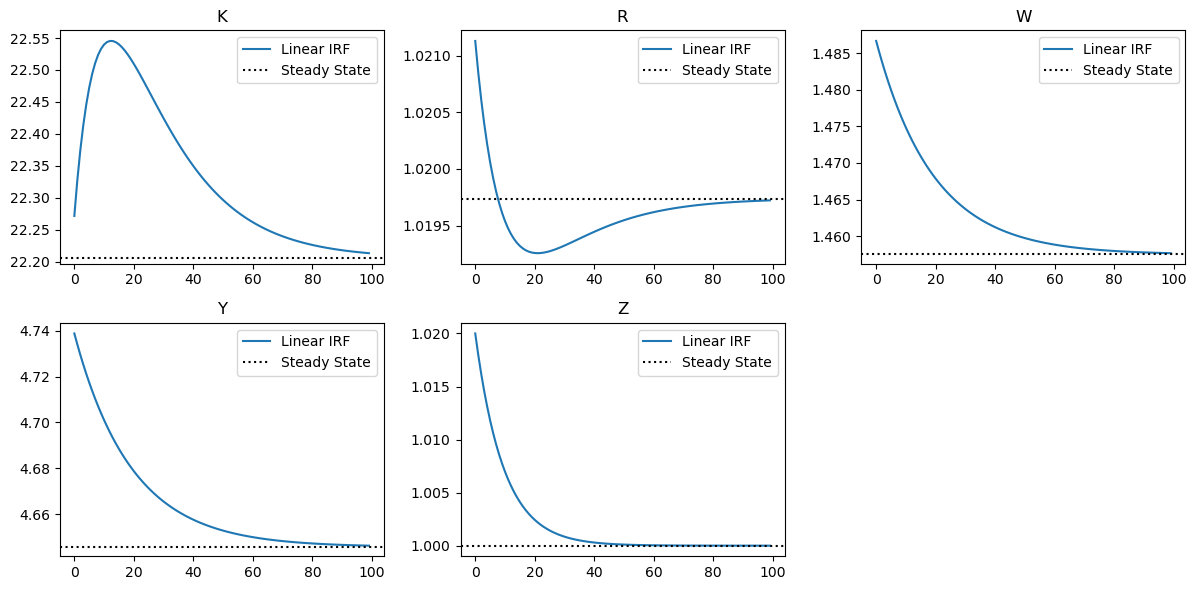

In [13]:
# solve for K
dK_path = G @ dZ_path

# get other paths, we use a linear extension since everyhting were doing is linearized
dRdK, dWdK, dYdK, dRdZ, dWdZ, dYdZ = get_derivs()  # derivitaives around steady state
dR_path = dZ_path * dRdZ + jnp.hstack((0, dK_path[:-1])) * dRdK  # do i treat K_l correct here?
dW_path = dZ_path * dWdZ + jnp.hstack((0, dK_path[:-1])) * dWdK
dY_path = dZ_path * dYdZ + jnp.hstack((0, dK_path[:-1])) * dYdK
K_path = K_ss + dK_path
R_path = R_ss + dR_path
W_path = W_ss + dW_path
Y_path = Y_ss + dY_path
Z_path = Z_ss + dZ_path

# plot it
t = 100
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
titles = ['K', 'R', 'W', 'Y', 'Z']
paths = [K_path, R_path, W_path, Y_path, Z_path]
X_ss = [K_ss, R_ss, W_ss, Y_ss, Z_ss]
for i in range(5):
    ax = axs.take(i)
    ax.plot(paths[i][:t], label='Linear IRF')
    ax.axhline(X_ss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
axs.take(5).set_axis_off()
fig.tight_layout()